# Experimento Practico Final AMQ2

## Integrantes:


*   Pedro Lucas Barrera - a1801
*   Lautaro Gabriel Medina - a1813



# ESTA INCOMPLETO, FALTA ADAPTAR 

# Importacion de librerias y seteo de variables de entorno

In [1]:
import awswrangler as wr

import mlflow

# Para que funciones, todos nuestros scripts debemos exportar las siguientes variables de entorno
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000
#%env MLFLOW_S3_ENDPOINT_URL=http://192.168.0.21:9000
#%env AWS_ENDPOINT_URL_S3=http://192.168.0.21:9000

env: AWS_ACCESS_KEY_ID=minio
env: AWS_SECRET_ACCESS_KEY=minio123
env: MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
env: AWS_ENDPOINT_URL_S3=http://localhost:9000


In [2]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from astropy.time import Time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import optuna
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
mlflow_server = "http://localhost:5001"
mlflow.set_tracking_uri(mlflow_server)

# Análisis general de datos y seleccion de features

El exprimento se realizara y visualizara completamente en MLFlow, por lo que se loguearan todos los datos y graficos relevantes ahi.

In [4]:
data_path = "s3://data/star_classification.csv"
data_raw =  wr.s3.read_csv("s3://data/star_classification.csv")

ClientError: An error occurred (InvalidAccessKeyId) when calling the ListObjectsV2 operation: The Access Key Id you provided does not exist in our records.

  Vemos cuantos datos unicos y nulos hay en el dataset

In [32]:

# Guardo descripcion y metricas de los datos en un dataframe
unique_values = {}
missing_values = {}
dtypes = {}

data_description = data_raw.describe()

# Create new rows for unique values and missing values
unique_values = pd.Series({col: data_raw[col].nunique() for col in data_raw.columns}, name='unique')
missing_values = pd.Series({col: data_raw[col].isnull().sum() for col in data_raw.columns}, name='missing')
dtypes = pd.Series({col: str(data_raw[col].dtype) for col in data_raw.columns}, name='dtype')
print(data_description)
# Add these new rows to the data_description DataFrame
data_description = pd.concat([data_description, 
                             pd.DataFrame([unique_values, missing_values, dtypes])], 
                             axis=0)

print(data_description)

"""
# Log as a table in MLflow
mlflow.log_table(
    data=column_stats.values.tolist(),
    column_names=column_stats.columns.tolist()
)
"""

             obj_ID          alpha          delta              u  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   1.237665e+18     177.629117      24.135305      21.980468   
std    8.438560e+12      96.502241      19.644665      31.769291   
min    1.237646e+18       0.005528     -18.785328   -9999.000000   
25%    1.237659e+18     127.518222       5.146771      20.352353   
50%    1.237663e+18     180.900700      23.645922      22.179135   
75%    1.237668e+18     233.895005      39.901550      23.687440   
max    1.237681e+18     359.999810      83.000519      32.781390   

                   g              r              i              z  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       20.531387      19.645762      19.084854      18.668810   
std        31.750292       1.854760       1.757895      31.728152   
min     -9999.000000       9.822070       9.469903   -9999.000000   
25%        18.965230      18.135828      1

'\n# Log as a table in MLflow\nmlflow.log_table(\n    data=column_stats.values.tolist(),\n    column_names=column_stats.columns.tolist()\n)\n'

Empezaremos en la eliminacion de algunas variables innecesarias.
Obj_ID es la variable de id de identificacion de cada observacion estelar, por lo que no nos sirve para nuestro analisis, se elimina la variable.

Por lo que podemos ver, rerun_ID tiene un solo valor que se repite para todas las filas. Esto significa que todos los datos se procesaron de la misma manera. Se eliminara esa variable.

spec_obj_ID tiene un valor distinto para cada observacion. Viendo el sitio web, se utiliza para unir otras tablas (como una foreing key). Por esto tambien se lo elimina.

Esta informacion de dominio del problema se obtuvo del siguiente sitio web del telescopio: https://www.sdss4.org/dr17/spectro/spectro_basics/

In [38]:
data = data_raw.drop(['rerun_ID', 'spec_obj_ID', 'obj_ID'], axis=1)

Hacemos una visualizacion inicial para darnos una mejor idea de la distribucion de los datos:


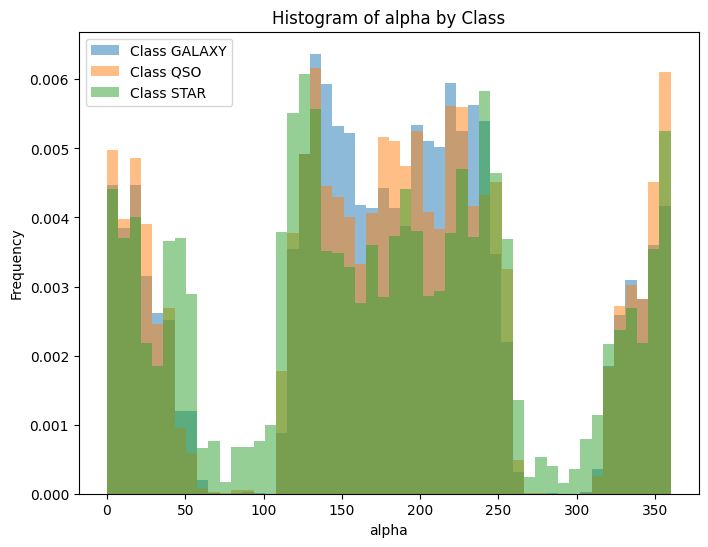

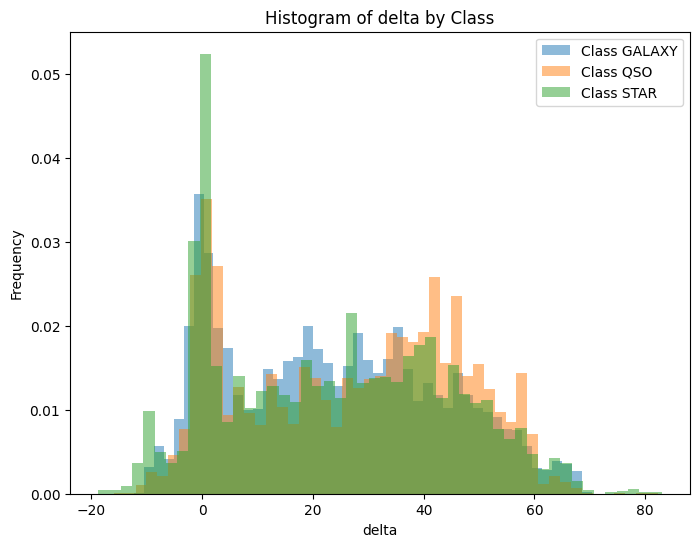

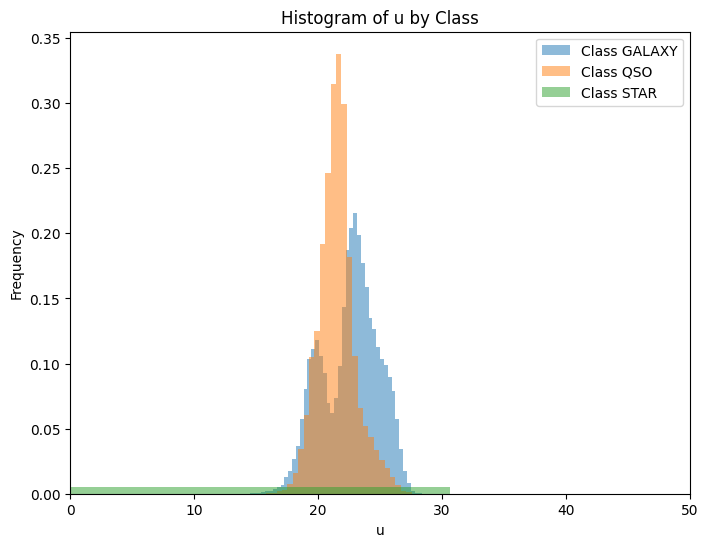

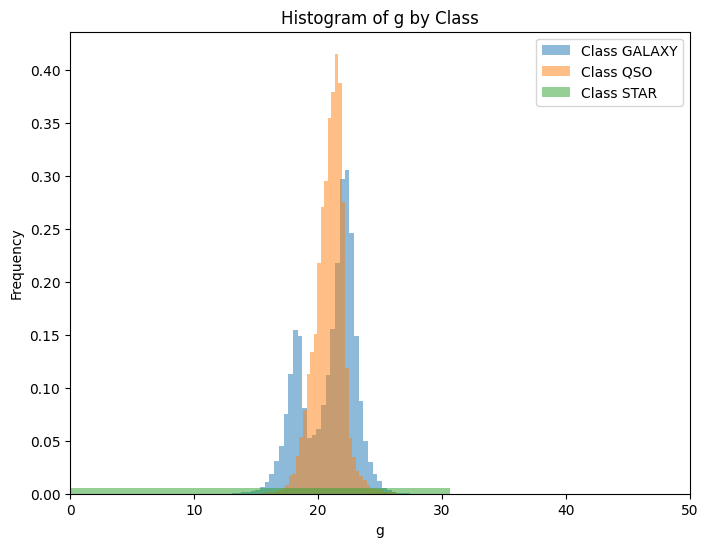

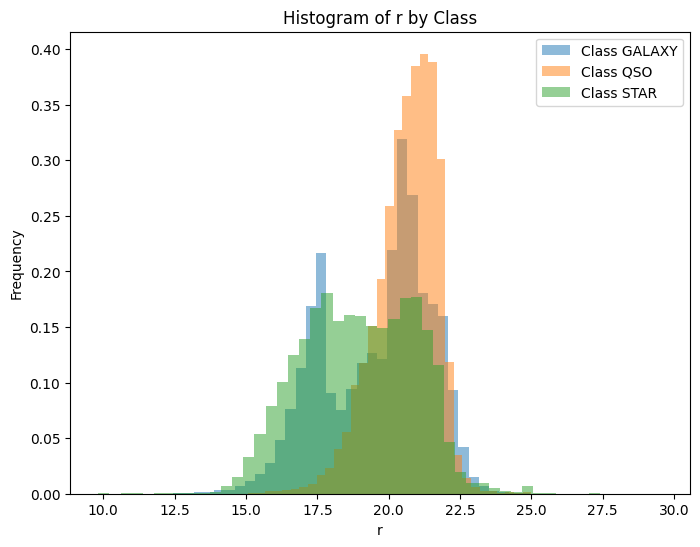

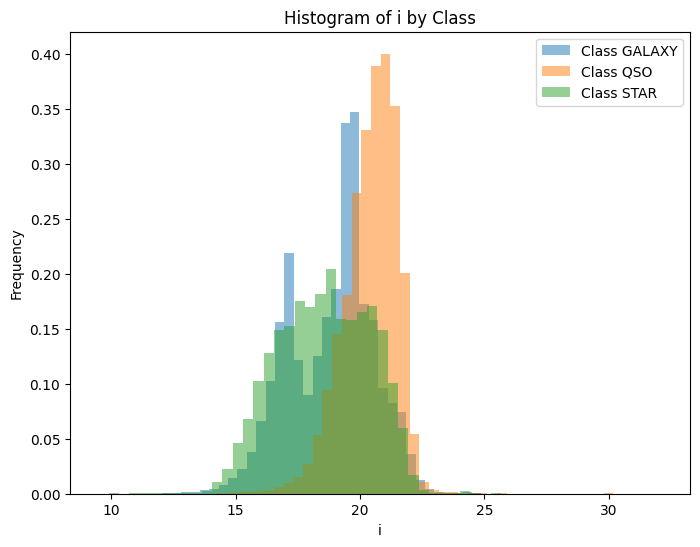

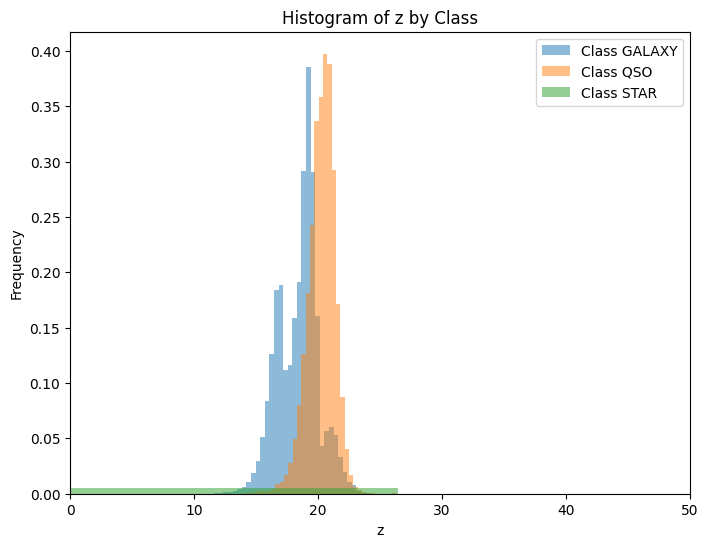

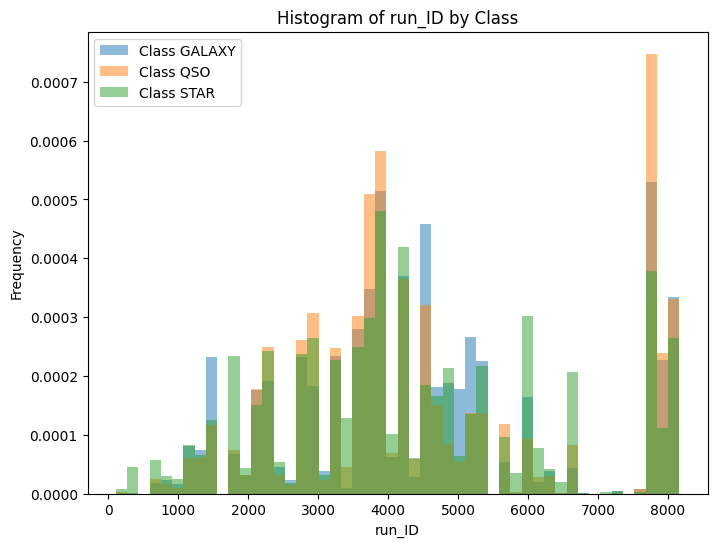

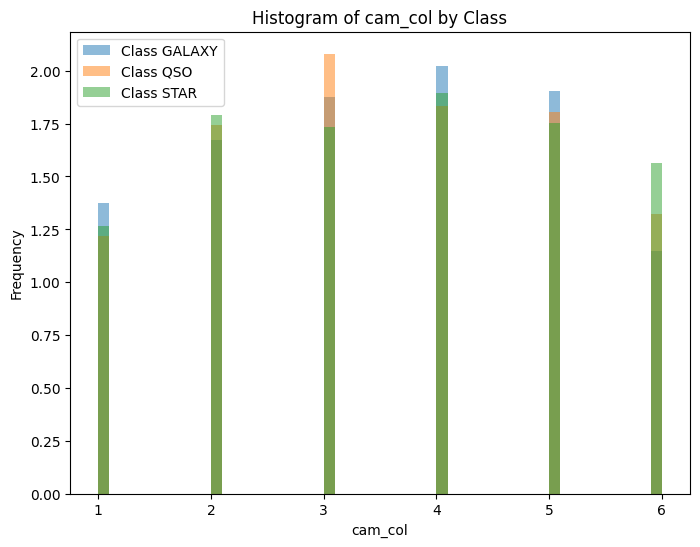

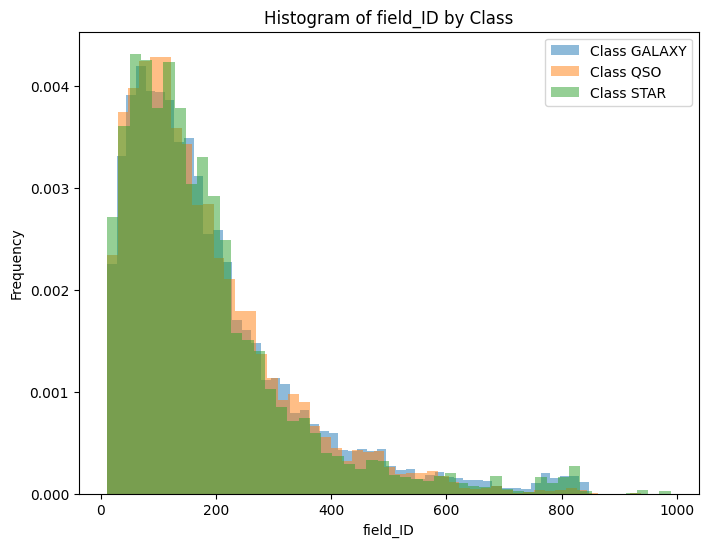

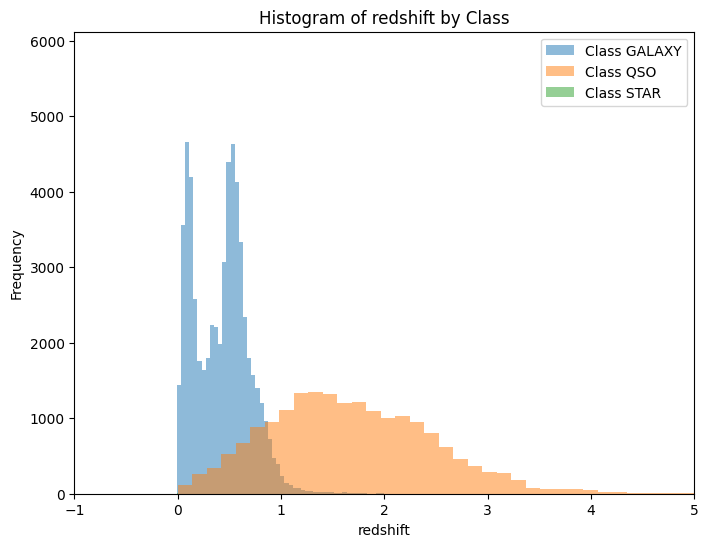

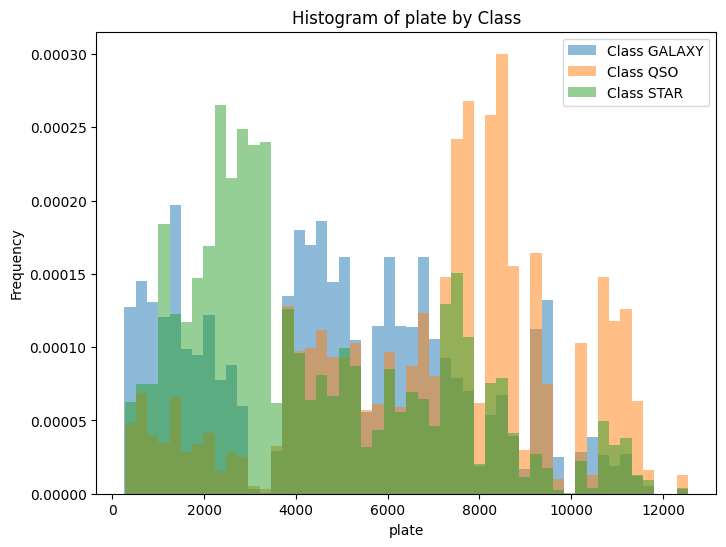

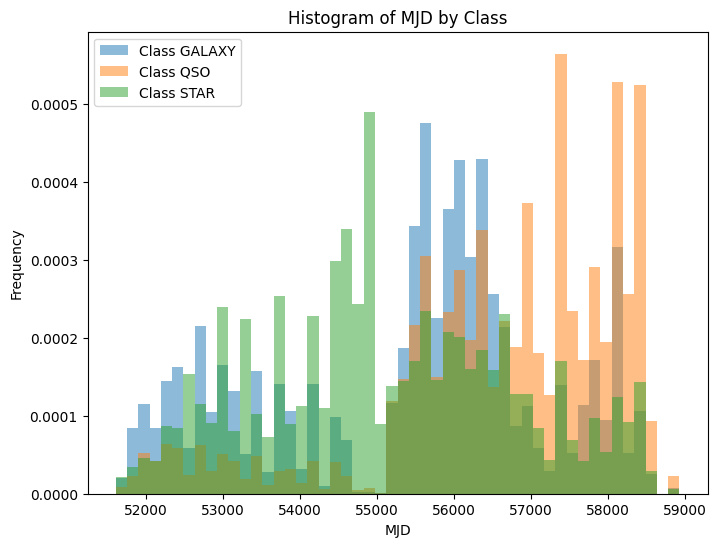

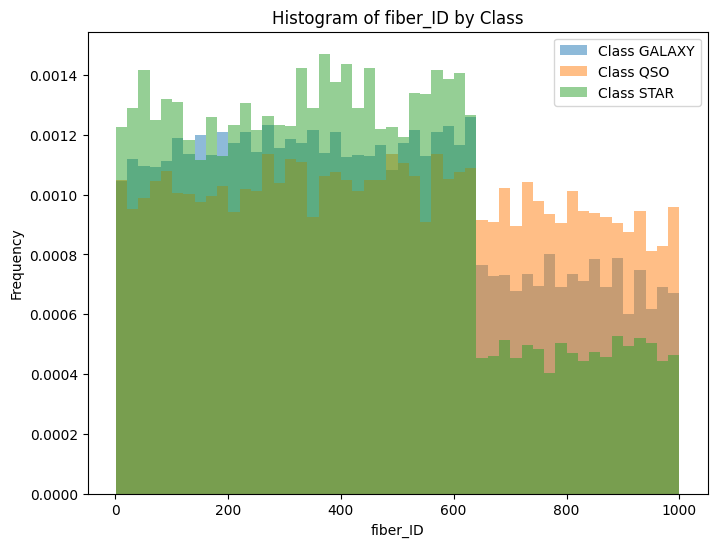

In [36]:
classes = data['class'].unique()

# Iterate over all columns except 'class'
for col in data.columns:
    if col != 'class':  # Skip the target column itself
        plt.figure(figsize=(8, 6))

        # Plot histograms for each class
        for cls in classes:
            subset = data[data['class'] == cls]
            if col == 'redshift':
              plt.hist(subset[col], bins=50, alpha=0.5, label=f"Class {cls}", density = False)
            else:
              plt.hist(subset[col], bins=50, alpha=0.5, label=f"Class {cls}", density = True)

        plt.title(f"Histogram of {col} by Class")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        if col == 'u':
          plt.xlim(0, 50)
        elif col == 'g':
          plt.xlim(0, 50)
        elif col == 'z':
          plt.xlim(0, 50)
        elif col == 'redshift':
          plt.xlim(-1, 5)
        plt.legend()
        plt.show()


In [ ]:
for cls in classes:
    print("CLASS: " + cls + "----------------------------------------------------------------------------------")
    subset = data[data['class'] == cls]
    print(subset.describe())

CLASS: GALAXY----------------------------------------------------------------------------------
              alpha         delta             u             g             r  \
count  59445.000000  59445.000000  59445.000000  59445.000000  59445.000000   
mean     177.954727     23.513911     22.587379     20.906101     19.587552   
std       94.403760     19.315205      2.264355      2.107755      1.874133   
min        0.005528    -12.364701     13.897990     12.679020     11.746640   
25%      131.506951      5.167016     20.794760     18.912680     17.817150   
50%      181.315787     22.301731     22.841770     21.582200     20.104590   
75%      231.333266     37.972697     24.207410     22.445130     20.974610   
max      359.994125     77.615588     29.325650     31.602240     29.571860   

                  i             z        run_ID       cam_col      field_ID  \
count  59445.000000  59445.000000  59445.000000  59445.000000  59445.000000   
mean      18.851990     18.449156 

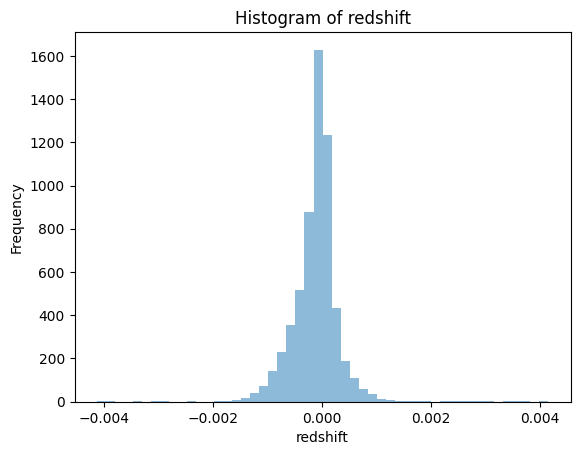

In [ ]:
plt.hist(data[data['class'] == 'STAR']['redshift'], bins=50, alpha=0.5, density = True)
plt.title("Histogram of redshift")
plt.xlabel("redshift")
plt.ylabel("Frequency")
plt.show()

Nos encontramos ahora con múltiples variables categóricas que tienen demasiados resultados posibles y por lo tanto dificultan su análisis.
Estas son: run_ID, field_ID, plate y fiber_ID.
Plate representa el número de placa de titanio que se instala en el telescopio cuando se ve un sector del espacio determinado, hay 1 placa por cada sector del que se tomó datos, por lo que hay alrededor de 6000 placas. No solo este numero es extremo para una variable categórica sino que hay otras 2 variables  que ya nos proveen de datos sobre la locación en el espacio (alpha: ángulo de ascensión del telescopio; y delta: ángulo de declinación)
Fiber_ID es el id de las fibras que se conectan a esta placa, una por cada espectro detectado. Puede que, cuando observaciones se hacen en diferentes días, las fibras se conectan de forma distinta y un mismo ID termina perteneciendo a más de una observación de espectro de luz.
Fuente: https://www.sdss4.org/dr17/spectro/spectro_basics/

In [39]:
data = data.drop(['run_ID','fiber_ID','plate','field_ID','cam_col'], axis=1)

Convertimos ahora MJD a un formato de fecha gregoriano para despues transformar la variable a una columna de meses.

In [ ]:
print(data['MJD'])

0        56354
1        58158
2        55592
3        58039
4        56187
         ...  
99995    57749
99996    56934
99997    54535
99998    56368
99999    57104
Name: MJD, Length: 100000, dtype: int64


In [42]:
data['Gregorian_Date'] = Time(data['MJD'], format='mjd').to_datetime()
data['Month'] = data['Gregorian_Date'].dt.month
data = data.drop(['Gregorian_Date'], axis=1)

Separamos el conjunto en entrenamiento y testeo, utilizando 80% de los datos para entrenamiento y 20% para testeo. Se setea un random state de 42 para mantener determinismo en la prueba y poder repetir los resultados.

In [43]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
# Print the shapes of the resulting DataFrames
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# Now you can work with train_df and test_df for training and evaluation

X_train = train_df.drop(['class'], axis=1)
y_train = train_df['class']
X_test = test_df.drop(['class'], axis=1)
y_test = test_df['class']

Training set shape: (80000, 11)
Testing set shape: (20000, 11)


In [44]:
numerical_cols = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift", "Month"]
#categorical_cols = ["class", "cam_col"]

scaler = StandardScaler()

train_df_norm = scaler.fit_transform(X_train[numerical_cols])

test_df_norm = scaler.transform(X_test[numerical_cols])

# Entrenamiento de modelos

Varios de los modelos se corrieron en otras notebooks/computadoras para correr en simultaneo y gastar menos tiempos. Por esto los resultados de algunos se presentaran como imagenes, pero se dejara el codigo que se utilizo para obtenerlos apra que pueda correrse y recrear los resultados.

## Regresion logistica

Primero haremos una prueba con regresión logística para intentar ver los resultados con un modelo simple. Para todos los modelos que intentaremos, primero se probara el resultado del modelo con parametros default y luego con optimziacion de hiperparametros. Considerando la simpleza de este modelo usaremos una búsqueda de grilla para intentar encontrar la mejor combinacion de hiperparametros.

Modelo con hiperparametros default

In [ ]:
logit = LogisticRegression()
df_train = pd.DataFrame(train_df_norm, columns=numerical_cols)
df_test = pd.DataFrame(test_df_norm, columns=numerical_cols)
logit.fit(df_train[numerical_cols], y_train)
y_pred = logit.predict(df_test[numerical_cols])
print("Reporte de clasificación:")
print(classification_report(test_df["class"], y_pred))

print("Precisión del modelo:", accuracy_score(test_df["class"], y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     11860
         QSO       0.94      0.87      0.91      3797
        STAR       0.94      1.00      0.97      4343

    accuracy                           0.95     20000
   macro avg       0.95      0.94      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Precisión del modelo: 0.9531


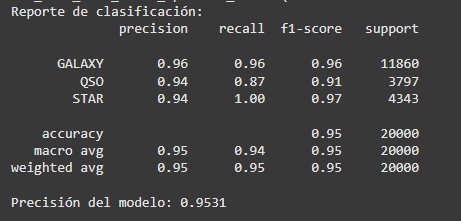

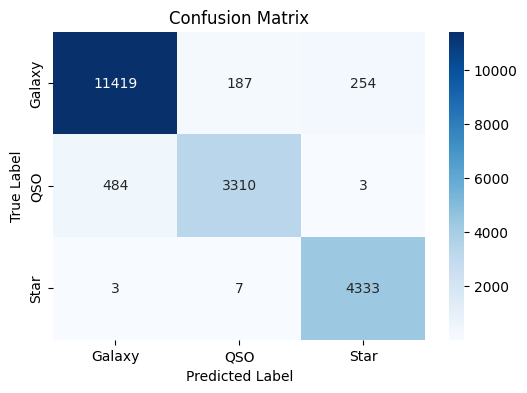

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'QSO', 'Star'], yticklabels=['Galaxy', 'QSO', 'Star'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Modelo con hiperparametros optimizados encontrados mediante busqueda en grilla

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

modelLogis = LogisticRegression()

param_grid = {
    'penalty': ['l1','l2','elasticnet', None],
    'solver': ['liblinear','newton-cg','lbfgs','sag','saga'],
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [1.0,0.1,0.01]} # Power parameter for the Minkowski metric
grid_search = GridSearchCV(modelLogis, param_grid, cv=5, refit = 'accuracy', return_train_score = True, scoring = 'accuracy',  n_jobs=-1)

grid_search.fit(train_df_norm, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model_rl = grid_search.best_estimator_
y_pred_logis = best_model_rl.predict(test_df_norm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_logis))
print("Test Accuracy:", accuracy_score(y_test, y_pred_logis))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
600 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "

Best Parameters: {'C': 0.01, 'l1_ratio': 1.0, 'penalty': None, 'solver': 'lbfgs'}
Best Score: 0.9615874999999999

Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     11860
         QSO       0.95      0.88      0.91      3797
        STAR       0.97      1.00      0.98      4343

    accuracy                           0.96     20000
   macro avg       0.96      0.95      0.96     20000
weighted avg       0.96      0.96      0.96     20000

Test Accuracy: 0.96165


![image.png](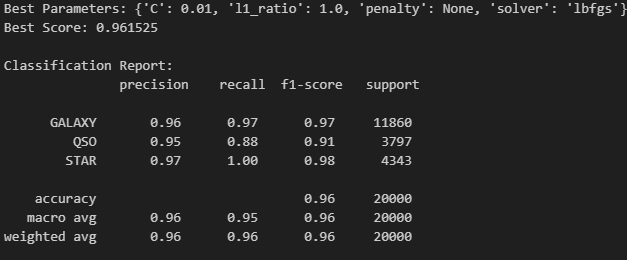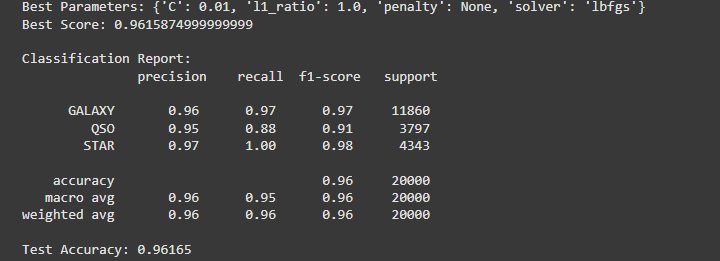)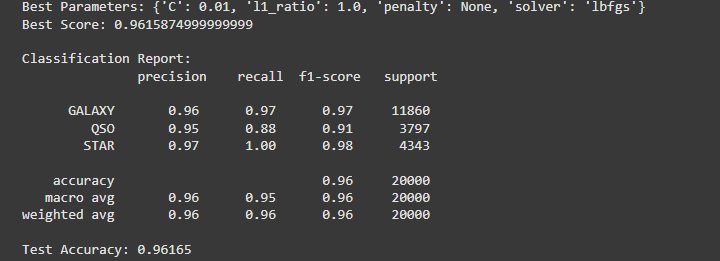

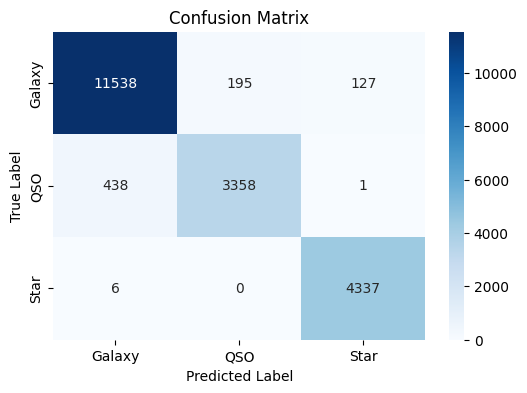

In [ ]:
cm = confusion_matrix(y_test, y_pred_logis)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'QSO', 'Star'], yticklabels=['Galaxy', 'QSO', 'Star'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Los resultados de regresion logistica ya son muy buenos, por lo que al tener tan buenos resultados con un modelo simple podriamos quedarnos con este. Sin embargo, vamos a probar 3 clasificadores mas y comparar resultados: KNN, SVM y XGBoost.

## KNN

Modelo con hiperparametros default

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
df_train = pd.DataFrame(train_df_norm, columns=numerical_cols)
df_test = pd.DataFrame(test_df_norm, columns=numerical_cols)
neigh.fit(df_train[numerical_cols], y_train)
y_pred = neigh.predict(df_test[numerical_cols])
print("Reporte de clasificación:")
print(classification_report(test_df["class"], y_pred))

print("Precisión del modelo:", accuracy_score(test_df["class"], y_pred))

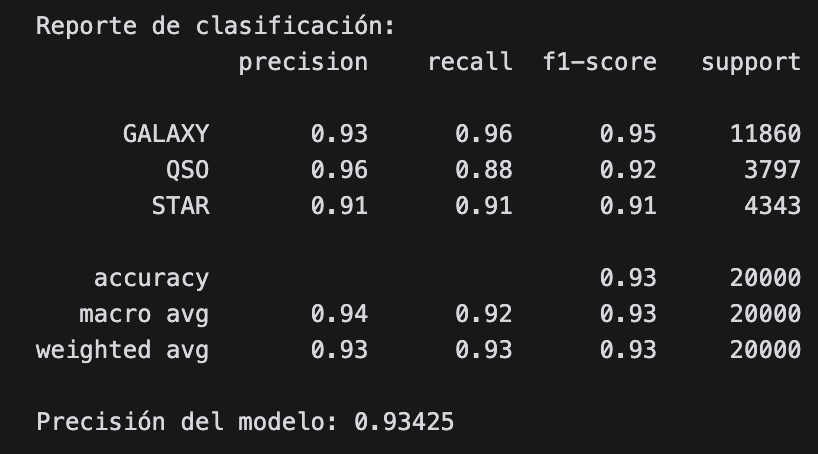

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'QSO', 'Star'], yticklabels=['Galaxy', 'QSO', 'Star'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

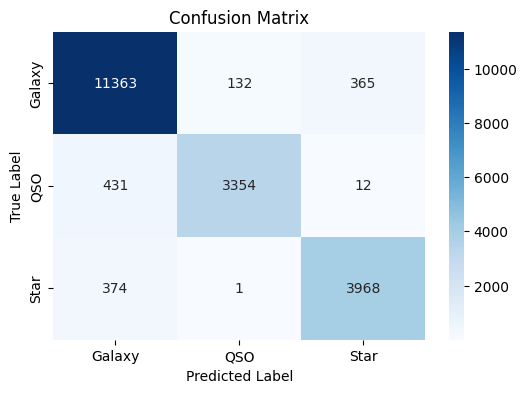

Modelo con hiperparametros optimizados encontrados con busqueda aleatoria

In [ ]:
df_train = pd.DataFrame(train_df_norm, columns=numerical_cols)
df_test = pd.DataFrame(test_df_norm, columns=numerical_cols)

model = KNeighborsClassifier()
param_distributions = {
    'n_neighbors': np.arange(1, 30, 1),          # Number of neighbors to consider
    'weights': ['uniform', 'distance'],          # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,              # Number of random combinations to try
    scoring='accuracy',     # Optimization metric
    cv=5,                   # 5-fold cross-validation
    random_state=42,
    n_jobs=-1               # Use all available CPU cores
)

random_search.fit(df_train, y_train)

print("Best Hyperparameters:", random_search.best_params)
print("Best Cross-Validation Accuracy:", random_search.best_score)
best_model = random_search.best_estimator
y_pred = best_model.predict(df_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)

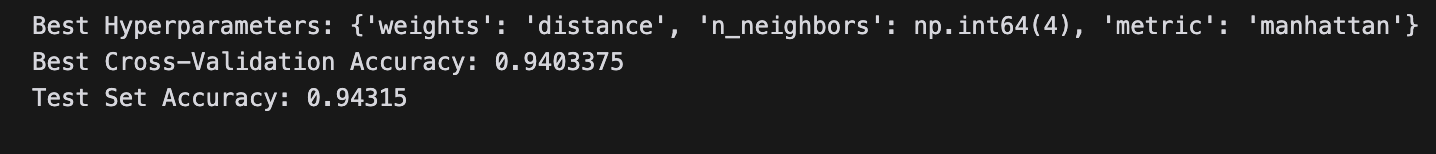

In [ ]:
print("Reporte de clasificación:")
print(classification_report(test_df["class"], y_pred))

print("Precisión del modelo:", accuracy_score(test_df["class"], y_pred))

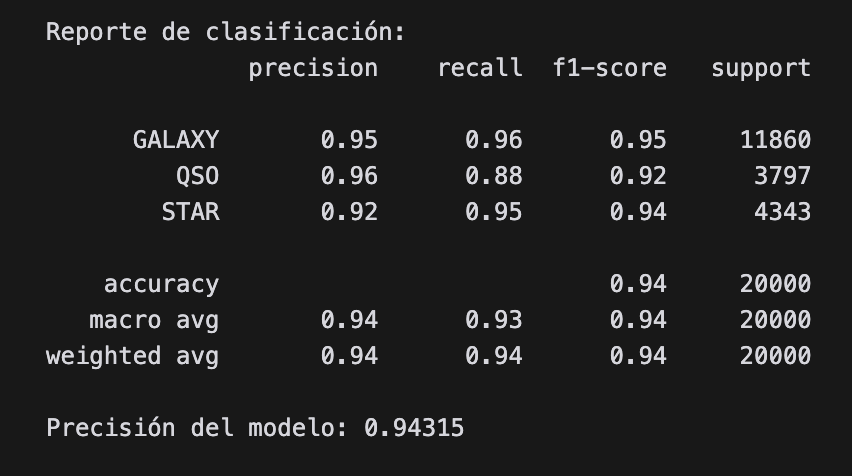

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'QSO', 'Star'], yticklabels=['Galaxy', 'QSO', 'Star'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

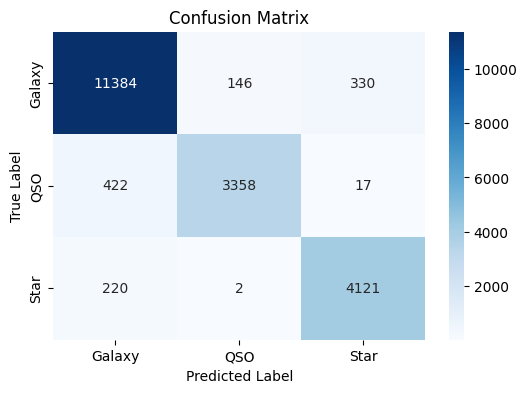

## SVM

Para SVM, la documentacion del modelo implementado por scikit-learn explcia que para una cantidad de datos mayor a decenas de miles (en este caso hay 80k en entrenamiento), el tiempo de fiteo puede ser demasiado elevado, debido a que el tiempo de fiteo crece cuadraticamente con la cantidad de parametros. Por eso, sugieren implementar metodos como LinearSVC o SGDClassifier. Optamos por la segunda. SGDClassifier (Stochastic Gradient Descent Classifier) es un modelo de aprendizaje supervisado que implementa clasificadores lineales utilizando el descenso de gradiente estocástico (SGD). Se utiliza principalmente para problemas de clasificación y soporta varios tipos de funciones de pérdida (loss functions), lo que permite ajustarse a diferentes contextos de clasificación.

Aunque el SGDClassifier no es un clasificador SVM clásico en el sentido estricto, puede aproximar el comportamiento de un SVM lineal al usar la función de pérdida hinge, que es la misma función de pérdida utilizada por un clasificador SVM lineal.

Fuente: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn-svm-svc

Hiperparametros default

In [ ]:
df_train = pd.DataFrame(train_df_norm, columns=numerical_cols)
df_test = pd.DataFrame(test_df_norm, columns=numerical_cols)

In [ ]:
sgd_svm = SGDClassifier(
    loss='hinge',           # Makes it equivalent to linear SVM          # L2 regularization       # Regularization strength
    learning_rate='optimal',
    max_iter=10000,         # Maximum number of iterations
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    validation_fraction=0.1, # Use 10% of training data for validation
    n_iter_no_change=80      # Stop if no improvement for 5 iterations
)

print("Training the model...")
sgd_svm.fit(df_train[numerical_cols], y_train)

y_pred = sgd_svm.predict(df_test[numerical_cols])

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))

NameError: name 'SGDClassifier' is not defined

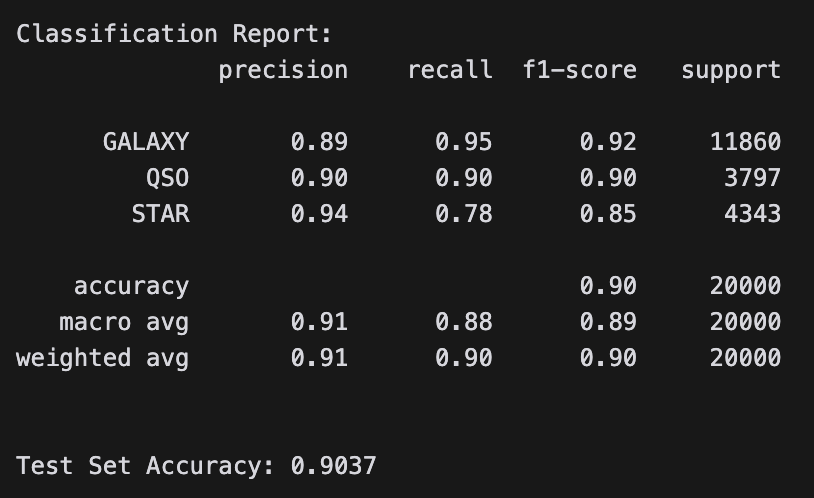

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'QSO', 'Star'], yticklabels=['Galaxy', 'QSO', 'Star'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

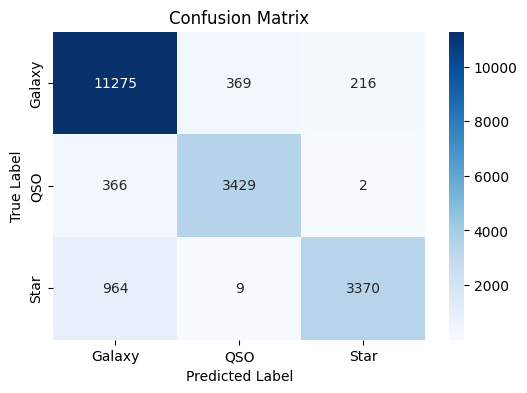

Hiperparametros optimizados. Para este caso utilizamos el metodo Optuna.

In [ ]:
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', ['optimal', 'adaptive', 'constant']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    }

    model = SGDClassifier(
            loss='hinge',           # Makes it equivalent to linear SVM
            random_state=42,
            n_jobs=-1,             # Use all CPU cores
            early_stopping=True,    # Enable early stopping
            validation_fraction=0.1, # Use 10% of training data for validation
            n_iter_no_change=5,     # Stop if no improvement for 5 iterations
            max_iter=1000,
            **params
        )

    model.fit(df_train[numerical_cols], y_train)
    y_pred = model.predict(df_test[numerical_cols])
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')

print("Starting optimization...")
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

print("\nBest trial:")
print("  Value (Accuracy): ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
final_model = SGDClassifier(
    loss='hinge',
    random_state=42,
    n_jobs=-1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    max_iter=1000,
    **best_params
)

final_model.fit(df_train[numerical_cols], y_train)

y_pred = final_model.predict(df_test[numerical_cols])

print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred))
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

NameError: name 'optuna' is not defined

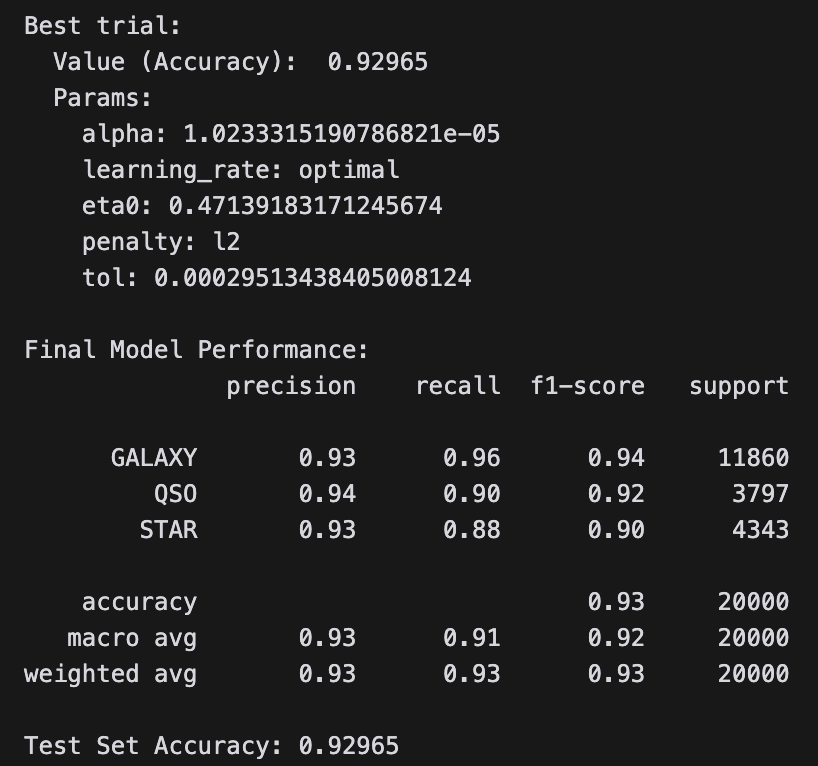

In [ ]:
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importances')
plt.show()


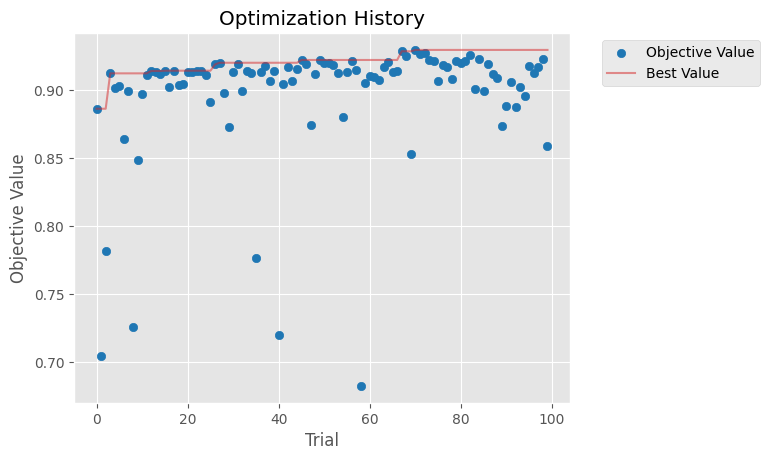

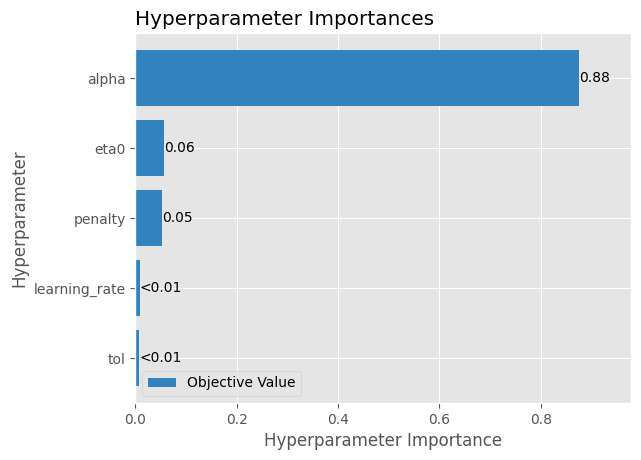

Optuna nos permite visualizar un grafico de importancia de cada hiperparametro encontrado mediante la optimziacion. Pareciera que optimizar alpha es lo mas importante, mientras que el resto, aunque con cierta relevancia, pareciera tener mucho menos impacto en el rendimiento del modelo la eleccion correcta del valor.

## XGBoost

Modelo con hiperparametros default

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

label_mapping = {'GALAXY': 0, 'QSO': 1, 'STAR': 2}

#Pasamos las claseses a variable numerica
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

xgb_model.fit(train_df_norm, y_train_mapped)

y_pred_xgb = xgb_model.predict(test_df_norm)

print("\nClassification Report for XGBoost:\n", classification_report(y_test_mapped, y_pred_xgb))
print("Test Accuracy:", accuracy_score(y_test_mapped, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     11860
           1       0.96      0.93      0.94      3797
           2       0.99      0.99      0.99      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000

Test Accuracy: 0.9758


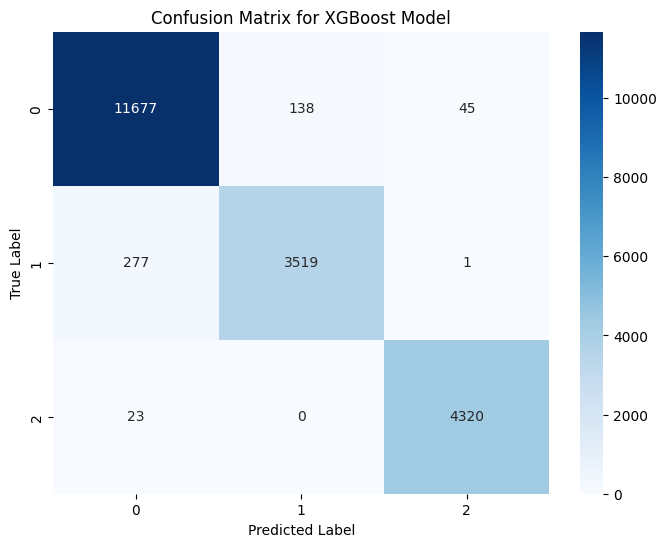

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_xgb)

# Create a heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,          # Display the numbers on the heatmap
    fmt='d',             # Format the numbers as integers
    cmap='Blues',        # Color map
    xticklabels=['GALAXY','QSO','STAR'],
    yticklabels=['GALAXY','QSO','STAR']
)

# Add labels, title, and adjust layout
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

Modelo con hiperparametros optimizados encontrados con busqueda aleatoria

In [ ]:
# Define the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter distributions
param_dist = {
    'n_estimators': [50, 100, 200, 300],       # Number of trees
    'max_depth': [3, 5, 7, 9, 12],             # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # Learning rate (step size shrinkage)
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],       # Fraction of features for each tree
    'gamma': [0, 1, 5, 10],                    # Minimum loss reduction for split
    'reg_alpha': [0, 0.1, 1, 10],              # L1 regularization
    'reg_lambda': [1, 5, 10, 20]               # L2 regularization
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Number of parameter combinations to try
    scoring='accuracy',       # Scoring metric
    cv=5,                     # Number of cross-validation folds
    verbose=2,                # Verbosity
    random_state=42,          # For reproducibility
    n_jobs=-1                 # Use all available cores
)

random_search.fit(train_df_norm, y_train_mapped)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:16:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5, 10],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9, 12],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1, 10],
                                        'reg_lambda': [1, 5, 10, 20],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Best parameters and cross-validation score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Train the best model
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(test_df_norm)

# Evaluate performance
print("\nClassification Report:\n", classification_report(y_test_mapped, y_pred))
print("Test Accuracy:", accuracy_score(y_test_mapped, y_pred))


Best Parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best Cross-Validation Score: 0.97645

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     11860
           1       0.96      0.93      0.94      3797
           2       0.99      0.99      0.99      4343

    accuracy                           0.98     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.98      0.97     20000

Test Accuracy: 0.97505


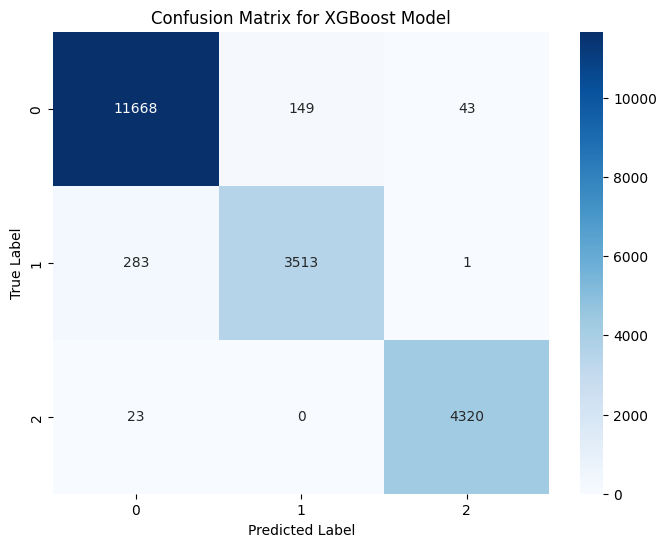

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred)

# Create a heatmap with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,          # Display the numbers on the heatmap
    fmt='d',             # Format the numbers as integers
    cmap='Blues',        # Color map
    xticklabels=['GALAXY','QSO','STAR'],
    yticklabels=['GALAXY','QSO','STAR']
)

# Add labels, title, and adjust layout
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()


# Conclusión

La idea del trabajo fue proabar varios clasificadores y metodos de seleccion de hiperparametros para tratar de utilizar multiples tecnicas vistas en la materia, con el objetivo final de definir el mejor clasificador con el mejor set de hiperparametros dentro de los que se probaron.

Podemos concluir que el modelo de regresion logistica dio excelentes resultados tanto con el metodo grid de seleccion de hyperparametros como con los hiperparametros default. Solo se vio superado por XGBoost, con una mejora en el accuracy cercano al 1.5%. Con mayor comprensión del dominio quizá podríamos determinar que es mejor, pero por ahora podemos decir que XGBoost es mas costoso pero con una accuracy mayor mientras que regresión logística es mas barato pero ligeramente peor.

También cabe considerar que la cantidad de datos de la variable objetivo (class) no esta balanceado, teniendo en el dataset total  59445 datos con clase GALAXY,  21594 con clase STAR Y 18961 con clase QSO. Se desconoce si el balance de los datos refleja la realidad por falta de conocimiento de dominio, pero, aunque aun sin realizarlo se consiguieron resultados muy positivos, para mejoras futuras se plantea la necesidad de probar técnicas para mitigar el impacto del desbalance de datos en el modelo. Entre estas podría estar quitar muestras de las clases mas representadas para proporcionar un balance similar entre las clases, hacer data augmentation sobre las clases sobrepresentadas o mantener la cantidad de datos y probar hiperparametros de ciertos clasificadores que permiten manejar el desbalance de clases asignandoles pesos a las observaciones, como por ejemplo scale_pos_weight de XGBoost, o el paquete compute_class_weight de scikit-learn.